# QAPLIB Figures

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
from pkg.gmp import quadratic_assignment
from pkg.gmp import quadratic_assignment_ot
import numpy as np

In [3]:
# hide
import sys
sys.path
sys.path.insert(0,'../../graspologic')

# QAPLIB Benchmark with barycenter init, random shuffle

In [4]:
qapprob = ["chr12c","chr15a","chr15c","chr20b","chr22b","esc16b",
          "rou12","rou15","rou20","tai12a","tai15a","tai17a","tai20a",
          "tai30a","tai35a","tai40a"]
# qapprob = ["lipa20a", "lipa20b", "lipa30a", "lipa30b", "lipa40a", "lipa40b",
#               "lipa50a", "lipa50b", "lipa60a", "lipa60b", "lipa70a", "lipa70b",
#               "lipa80a", "lipa90a", "lipa90b"]
# qapprob =["sko100a", "sko100b", "sko100c", "sko100d", "sko100e", "sko100f",]
n_qap = len(qapprob)
slnfile = np.load("../data/qaplib/qap_sols.npz",allow_pickle=True)
datafile = np.load("../data/qaplib/qap_probs.npz",allow_pickle=True)
n_qap = len(qapprob)

gm_scores = np.zeros(n_qap)
gmot_scores = np.zeros(n_qap)

for i in range(n_qap):

    A = datafile[qapprob[i]][0]
    B = datafile[qapprob[i]][1]
    n = A.shape[0]

    res = quadratic_assignment(A,B,options={'tol':1e-9,'maxiter':100, 'shuffle_input':True})          
    gm_scores[i] = res.fun
    
    res = quadratic_assignment_ot(A,B,options={'tol':1e-9,'maxiter':100, 'shuffle_input':True, 'reg': 100, 'thr':1e-2})       
    gmot_scores[i] = res.fun

In [5]:
import pandas as pd
opt = [slnfile[i] for i in qapprob]
mat = np.zeros((n_qap,3))
mat[:,0] = opt
mat[:,1] = gm_scores
mat[:,2] = gmot_scores
mat = mat.astype(int)
df = pd.DataFrame(mat,columns=["OPT","GM", 'GM_OT'])
df.insert(0,"QAP",qapprob,True)
print(df)

       QAP      OPT       GM    GM_OT
0   chr12c    11156    13072    12850
1   chr15a     9896    16398    14840
2   chr15c     9504    19206    16284
3   chr20b     2298     2986     3422
4   chr22b     6194     8420     7482
5   esc16b      292      320      316
6    rou12   235528   253420   243392
7    rou15   354210   369342   370696
8    rou20   725522   743884   742606
9   tai12a   224416   244672   224416
10  tai15a   388214   397376   402248
11  tai17a   491812   509656   499528
12  tai20a   703482   734276   771754
13  tai30a  1818146  1880064  1869814
14  tai35a  2422002  2460940  2498962
15  tai40a  3139370  3227612  3180126


# QAPLIB with Random Inits

In [6]:
qapprob = ["chr12c","chr15a","chr15c","chr20b","chr22b","esc16b",
          "rou12","rou15","rou20","tai12a","tai15a","tai17a","tai20a",
          "tai30a","tai35a","tai40a"]
# qapprob = ["lipa20a", "lipa20b", "lipa30a", "lipa30b", "lipa40a", "lipa40b",
#               "lipa50a", "lipa50b", "lipa60a", "lipa60b", "lipa70a", "lipa70b",
#               "lipa80a", "lipa90a", "lipa90b"]
# qapprob =["sko100a", "sko100b", "sko100c", "sko100d", "sko100e", "sko100f",]
n_qap = len(qapprob)
n_qap = len(qapprob)
bari_scores = np.zeros(n_qap)
no_shuffle = np.zeros(n_qap)
den = 1 #controls number of barycenter inits
for i in range(n_qap):
    b_min = np.zeros(den)
    for k in range(den):
        A = datafile[qapprob[i]][0]
        B = datafile[qapprob[i]][1]
        n = A.shape[0]

        res = min([quadratic_assignment(A,B,options={'tol':1e-6,'maxiter':100,'P0':'randomized'})
                   for i in range(30)], key=lambda x: x.fun)
                                   #options={'rng':i+k} )
        b_min[k] = res.fun
        res = min([quadratic_assignment_ot(A,B, options={'tol':1e-6,'maxiter': 100, 'P0': 'randomized'})
                   for i in range(30)], key=lambda x: x.fun)
        
    bari_scores[i] = min(b_min)
    no_shuffle[i] = res.fun

In [7]:
import pandas as pd
opt = [slnfile[i] for i in qapprob]
mat = np.zeros((n_qap,3))
mat[:,0] = opt
mat[:,1] = bari_scores
mat[:,2] = no_shuffle
mat = mat.astype(int)
df = pd.DataFrame(mat,columns=["OPT","GM", 'GM_OT'])
df.insert(0,"QAP",qapprob,True)
print(df)

       QAP      OPT       GM    GM_OT
0   chr12c    11156    12910    11566
1   chr15a     9896    12596    10632
2   chr15c     9504    12682    12324
3   chr20b     2298     2884     2702
4   chr22b     6194     7468     7060
5   esc16b      292      292      292
6    rou12   235528   235528   238134
7    rou15   354210   354210   359748
8    rou20   725522   728724   731916
9   tai12a   224416   224416   224416
10  tai15a   388214   392712   392712
11  tai17a   491812   501016   496598
12  tai20a   703482   710350   705622
13  tai30a  1818146  1850676  1828454
14  tai35a  2422002  2461826  2431498
15  tai40a  3139370  3186970  3179110


# Recreate fig 4 from FAQ Paper

In [11]:
from os import listdir
from os.path import isfile, join

qapprob = ["bur26a", "bur26b", "bur26c", "bur26d", "bur26e", "bur26f",
              "bur26g", "bur26h", "chr12a", "chr12b", "chr12c", "chr15a",
              "chr15b", "chr15c", "chr18a", "chr18b", "chr20a", "chr20b",
              "chr20c", "chr22a", "chr22b", "chr25a",
              "els19",
              "esc16a", "esc16b", "esc16c", "esc16d", "esc16e", "esc16g",
              "esc16h", "esc16i", "esc16j", "esc32e", "esc32g", "esc128",
              "had12", "had14", "had16", "had18", "had20", "kra30a",
              "kra30b", "kra32",
              "lipa20a", "lipa20b", "lipa30a", "lipa30b", "lipa40a", "lipa40b",
              "lipa50a", "lipa50b", "lipa60a", "lipa60b", "lipa70a", "lipa70b",
              "lipa80a", "lipa90a", "lipa90b",
              "nug12", "nug14", "nug16a", "nug16b", "nug17", "nug18", "nug20",
              "nug21", "nug22", "nug24", "nug25", "nug27", "nug28", "nug30",
              "rou12", "rou15", "rou20",
              "scr12", "scr15", "scr20",
              "sko42", "sko49", "sko56", "sko64", "sko72", "sko81", "sko90",
              "sko100a", "sko100b", "sko100c", "sko100d", "sko100e", "sko100f",
              "ste36b", "ste36c",
              "tai12a", "tai12b", "tai15a", "tai15b", "tai17a", "tai20a",
              "tai20b", "tai25a", "tai25b", "tai30a", "tai30b", "tai35a",
              "tai40a", "tai40b", "tai50a", "tai50b", "tai60a", "tai60b",
              "tai64c", "tai80a", "tai100a", "tai100b", "tai150b", "tai256c",
              "tho30", "tho40", "tho150", "wil50", "wil100"]

n_qap = len(qapprob)

sizes = np.zeros(n_qap)
logofv = np.zeros(n_qap)
for i in range(n_qap):

    A = datafile[qapprob[i]][0]
    B = datafile[qapprob[i]][1]
    n = A.shape[0]
    sizes[i] = n

    res = quadratic_assignment(A,B,options={'tol':1e-9,'maxiter':100, 'shuffle_input':True})          
    gm_score = res.fun
    
    res = quadratic_assignment_ot(A,B,options={'tol':1e-9,'maxiter':100, 'shuffle_input':True, 'reg': 100, 'thr':1e-2})       
    logofv[i] = np.log(res.fun/gm_score)
    

0.39344262295081966


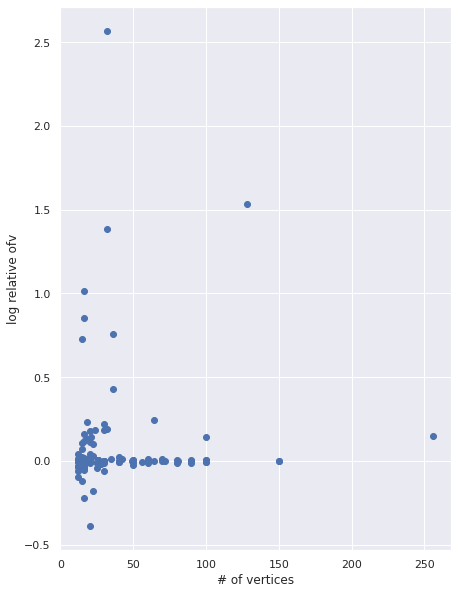

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
sns.set(rc={'figure.figsize':(7,10)})
plt.scatter(sizes,logofv)
plt.xlabel('# of vertices')
plt.ylabel('log relative ofv')


In [12]:
print(f'percent better = {np.sum(logofv < 0)/n_qap}')

percent better = 0.319672131147541
